In [1]:
""" Basic preprocessing"""
import numpy as np
import pandas as pd
import datetime
import re

""" Sentiment analysis """
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


In [2]:
df = pd.read_csv('btc_bitcoin.csv')
df_april = pd.read_csv('btc_data_2022_val.csv')
df_2021 = pd.read_csv('btc_data_2021_2022.csv')

In [3]:
frame = [df_april, df, df_2021]
df_btc = pd.concat(frame)
df_btc.head()

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,0,1460249327394164739,devvaaaaaaa,10,664,"ᖴᖇᝪᗰ Ꭲᕼᗴ ᗴᗩᔑᎢ ᑕᝪᗩᔑᎢ, しᏆᐯᗴ ᗷᎩ ᗴ᙭ᗩᗰᑭしᗴ, ᑕᝪᑎᔑᗴᖇᐯᗩ...",NaN,Want to wake up in the morning without financi...,2022-04-20 23:59:55+00:00,12,1,18,0
1,1,1501922448324927500,LivePriceCrypto,1272,67379,I Tweet the latest #Bitcoin & #Ethereum price ...,NaN,#Bitcoin Last Price $41368 #BTC 🚀\nDaily Indic...,2022-04-20 23:59:52+00:00,0,0,0,0
2,2,1502555711460495362,theashleepage11,330,762,Deep Value Investor . . . 📄📑📉👩‍💻 NFTs Advocate...,Ocean city,Give a man #bitcoin and he trades it. Teach a...,2022-04-20 23:59:52+00:00,0,0,3,0
3,3,1502555711460495362,theashleepage11,330,762,Deep Value Investor . . . 📄📑📉👩‍💻 NFTs Advocate...,Ocean city,If you think there is a point where bitcoin is...,2022-04-20 23:59:48+00:00,0,1,4,0
4,4,771448125651247104,SkylerColbert,1872,1039,Community Builder | Accumulating & Busy @ @Luv...,"Costa Mesa, CA",A lot of people are unaware of how early we al...,2022-04-20 23:59:46+00:00,4,2,12,0


In [4]:
def derive_statistics(df):
    hashtag = df['text'].apply(lambda x: re.findall(r'#(\w+)', x))
    df['count_hashtag'] = hashtag.apply(lambda x: len(x))
    percentile = np.percentile(df['count_hashtag'], 95)

    print(f'Two stds from mean hashtag: {percentile}')

    dollar = df['text'].apply(lambda x: re.findall(r'(?<=\s)\$\w+', x))
    df['count_dollar'] = dollar.apply(lambda x: len(x))
    percentile = np.percentile(df['count_dollar'], 95)
    
    print(f'Two stds from mean dollar_sign: {percentile}')  

    accounts = df['username'].value_counts()
    percentile = np.percentile(accounts, 99)

    print(f'max allowed tweets per account: {percentile}')



In [5]:
derive_statistics(df_btc)

Two stds from mean hashtag: 11.0
Two stds from mean dollar_sign: 7.0
max allowed tweets per account: 79.0


In [6]:
""" Criteria for spam"""
spam_words = ['giveaway', 'giveaways', 'give away', 'give aways', 'airdrop', 'airdrops'] 

bots = ['pump', 'register', 'join', 'retweet', 'retweets']

username_includes = 'bot'

max_followers = 100

max_hashtag = 11

max_dollar_sign = 7

max_tweets_account = 79


In [7]:
def remove_bot_spam(df):
    
    df = df[df["clean_text"].str.contains('giveaway|giveaways|give away|give aways|airdrop|airdrops')==False] ## remove tweets with spam words

    df = df[df["author_description"].str.contains('giveaway|giveaways|give away|give aways|airdrop|airdrops|track|tracking|bot|tweet|whale|whales|follow|daily')==False] ## remove account with spam or bot words in description 

    df = df[df["clean_text"].str.contains('pump|register|join|retweet|retweets')==False] ## remove tweet with bot words
      
    df = df[~df.username.str.contains(username_includes)] ## remove tweets with username including the word bot

    df = df[df.author_followers >= max_followers] #Cut of accounts with less than minimum allowed followers

    df = df[df.count_hashtag < max_hashtag]     #Cut of tweets with more than maximum allowed hastags

    df = df[df.count_dollar < max_dollar_sign]  #Cut of tweets with more than maximum allowed dollar_signs

    df =  df.groupby('username').filter(lambda x: len(x) < 44) #filter dataframe by users with less than 99 percentile amount of tweets

    df = df.drop_duplicates(subset=['text'], keep=False)

    df = df.reset_index()

    return df

In [8]:
def cleanText(text):
    """ lower rext """    
    text = text.lower() 

    """ replace whitespace"""
    text = text.replace('\n', ' ')
    
    """ remove dollar sign"""
    text = text.replace("$", "")
    
    """ remove Hastag"""
    text = re.sub(r'#([^\s]+)', r'\1', text) 

    """ Remove unicode"""
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)     

    """Remove unicode """
    text = re.sub(r'[^\x00-\x7f]',r'',text)  

    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)

    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)

    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)

    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)

    return text

In [9]:
def clean_author_description(text):
    text = str(text)
    text = text.lower()
    text = text.replace("$", "")
    text = re.sub(r'#([^\s]+)', r'\1', text) 

    return text


In [10]:
def sentiment_analyzer_scores(df):
    scores = analyser.polarity_scores(df)
    neg = scores['neg']
    neu = scores['neu']
    pos = scores['pos']
    comp = scores['compound']
    return neg, neu, pos, comp

In [11]:
def update_df(df):
    df['Date'] = pd.to_datetime(df['created_at']).dt.date
    df_btc['count_tweet']  = 1
    df = df[['text', 'Date', 'clean_text', 'count_tweet']]
    df = df.copy()
    return df

In [12]:
def sentiment_analyzer_scores(df):
    scores = analyser.polarity_scores(df)
    neg = scores['neg']
    neu = scores['neu']
    pos = scores['pos']
    comp = scores['compound']
    return neg, neu, pos, comp

In [13]:
df_btc['clean_text'] = df_btc['text'].apply(cleanText)

In [14]:
df_btc = remove_bot_spam(df_btc)

In [15]:
df_btc['author_description'] = df_btc['author_description'].apply(clean_author_description)

In [16]:
test_df = update_df(df_btc)

In [17]:
""" Read price data and merge with sentiment dataframes """

""" process economic uncertainty data """
df_teu = pd.read_excel("Twitter_Economic_Uncertainty.xlsx") # read twitter uncertainty data
df_teu.rename(columns= {"date": 'Date'}, inplace=True)
df_teu['Date'] = df_teu['Date'].dt.date

""" Process btc price data"""
btc_price = pd.read_csv("BTC-USD.csv") # read price data
btc_price['Date'] = pd.to_datetime(btc_price['Date']).dt.date #change datetime column
btc_price = btc_price.merge(df_teu, on = 'Date') #merge uncertainty measures with price data

""" Apply sentiment analysis and process df"""
applied_df = test_df.apply(lambda row: sentiment_analyzer_scores(row.clean_text), axis='columns', result_type='expand') #apply sentiment analyizer and store in seperate df
test = pd.concat([test_df, applied_df], axis='columns') #concat dataframes
test.rename(columns = {0:'neg', 1:'neu', 2:'pos', 3:'comp'}, inplace = True) #rename columns
test = test.groupby(test_df['Date']).mean() # Take mean daily scores of input variables

""" Tweets per day """
tweets = test_df.groupby("Date")['count_tweet'].sum()
test = test.merge(tweets, on = 'Date')


""" Merge into final dataset """
df = test.merge(btc_price, on='Date') #merge both dataframes together
df.rename(columns = {'count_tweet_y':'count_tweet'}, inplace = True) #rename columns
df = df.drop('count_tweet_x', axis=1)
# df = df.drop(['snapped_at', 'market_cap', 'total_volume'], axis=1)

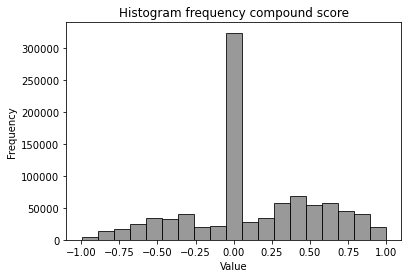

In [18]:
import matplotlib.pyplot as plt

def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram frequency compound score")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(applied_df.iloc[:, 3])

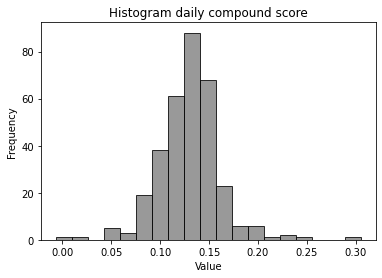

In [19]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram daily compound score")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['comp'])

In [20]:
df.to_csv('last_dataset.csv')